# Load b1555 data
### JX, 10/11/2021
> Load b1555 song data for artificial song generation  
> settings from https://github.com/timsainb/avgn_paper/blob/V2/notebooks/01.1-syllabic-segmentation/starling-syllable-segmentation.ipynb


In [1]:
from starling_rhythm.utils.paths import PROCESSED_DIR

## Import Dataframe

In [2]:
import pandas as pd

In [3]:
SAVE_PATH = PROCESSED_DIR / 'starling_b1555_amp_envs200.pickle'
ae_df = pd.read_pickle(SAVE_PATH).reset_index()

In [4]:
ae_df.head()

,index,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,...,peaks_p,n_peaks,l_p_ratio,waveform,valid_waveform,valid,spectrogram,confusing,is_call,amp_env
0,0,508500,566065,24408000,27171120,"[28.88509981238539, 65.14898407709249, 103.180...",9.609107,143.211264,True,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,...,"[5, 292, 515, 688, 872, 1142, 1152, 1172, 1180...",472,121.959746,"[-5, -5, -5, -5, -3, -5, -5, -4, -6, -4, -2, -...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,False,"[2.4892911824281327e-05, 0.002640440361574292,..."
1,1,641180,694125,30776640,33318000,"[48.20694858466058, 83.76981436987464, 108.852...",5.388905,156.745806,True,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,...,"[5, 254, 590, 597, 784, 936, 1167, 1638, 1648,...",555,95.396396,"[3, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, -1, -1, -...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,False,"[5.805372893519234e-06, 0.0016227918677031994,..."
2,2,868940,921030,41709120,44209440,"[2.3001409701376363, 15.027985352733767, 30.17...",8.135380,156.958417,True,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,...,"[6, 16, 520, 532, 542, 568, 596, 1162, 1180, 1...",400,130.225000,"[-11, -11, -11, -11, -12, -11, -11, -11, -10, ...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,False,"[9.765496361069381e-05, 0.007925855927169323, ..."
3,3,1043035,1093720,50065680,52498560,"[2.9249842953419494, 3.1541257656248125, 14.16...",8.135380,144.054406,True,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,...,"[6, 13, 20, 611, 620, 632, 641, 648, 1233, 124...",276,183.641304,"[-2, -2, -1, -2, -2, -2, -3, -3, -3, -3, -3, -...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,False,"[5.769828931079246e-05, 0.015915358439087868, ..."
4,4,1423905,1474480,68347440,70775040,"[3.937345912388517, 3.469701876813218, 2.86553...",4.015413,140.816750,True,/mnt/sphere/speech_bci/raw_data/s_b1555_22/202...,...,"[7, 14, 28, 37, 46, 58, 68, 80, 92, 102, 109, ...",641,78.900156,"[6, 5, 5, 5, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, ...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,False,"[5.337237780622672e-06, 0.0012986172223463655,..."


## Segment

In [5]:
import numpy as np
from avgn.signalprocessing.filtering import butter_bandpass_filter
from starling_rhythm.utils.audio import int16_to_float32
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation, plot_segmented_spec, plot_segmentations

/home/AD/j8xing/avgn_paper/avgn/utils/general.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [6]:
### segmentation parameters
min_level_db = -100 ## default dB minimum of spectrogram (threshold anything below)
min_level_db_floor = -60 ## highest number min_level_db is allowed to reach dynamically
db_delta = 5 ## delta in setting min_level_db
n_fft = 1024 ## FFT window size
hop_length_ms = 1 ## number audio of frames in ms between STFT columns
win_length_ms = 5 ## size of fft window (ms)
ref_level_db = 20 ## reference level dB of audio
pre = 0.97 ## coefficient for preemphasis filter
spectrogram_range = None ## spectral range to care about for spectrogram
verbose = False ## display output
mask_thresh_std = 1 ## standard deviations above median to threshold out noise (higher = threshold more noise)
neighborhood_time_ms = 5 ## size in time of neighborhood-continuity filter
neighborhood_freq_hz = 500 ## size in Hz of neighborhood-continuity filter
neighborhood_thresh = 0.5 ## threshold number of neighborhood time-frequency bins above 0 to consider a bin not noise
min_syllable_length_s = 0.01 ## shortest expected length of syllable
min_silence_for_spec = 0.001 ## shortest expected length of silence in a song (used to set dynamic threshold)
silence_threshold = 0.0 ## threshold for spectrogram to consider noise as silence
max_vocal_for_spec = 2.0 ## longest expected vocalization in seconds
temporal_neighbor_merge_distance_ms = 0 ##longest distance at which two elements should be considered one
overlapping_element_merge_thresh = np.inf ##proportion of temporal overlap to consider two elements one
min_element_size_ms_hz = [0,0] ## smallest expected element size (in ms and Hz). Everything smaller is removed
butter_min = 500
butter_max = 15000
figsize = (20,5)


## replicate sainburg: 

In [7]:
### segmentation parameters
n_fft=1024
hop_length_ms=1
win_length_ms=5
ref_level_db=20
pre=0.97
min_level_db=-100
min_level_db_floor = -60
db_delta = 5
silence_threshold = 0.01
min_silence_for_spec=0.1
max_vocal_for_spec=2.0,
min_syllable_length_s = 0.15
butter_min = 500
butter_max = 15000

In [8]:
def segment_spec_custom(data, rate, plot = True):
    
    ## coerce data to float32
    data = int16_to_float32(data)
    
    ## pass data through a filter
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)
    
    ## segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=False,
        min_syllable_length_s=min_syllable_length_s,
    )
    
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
        )
        plt.show()
        
    return {'onsets': results['onsets'], 
            'offsets': results['offsets']}

In [9]:
import matplotlib.pyplot as plt

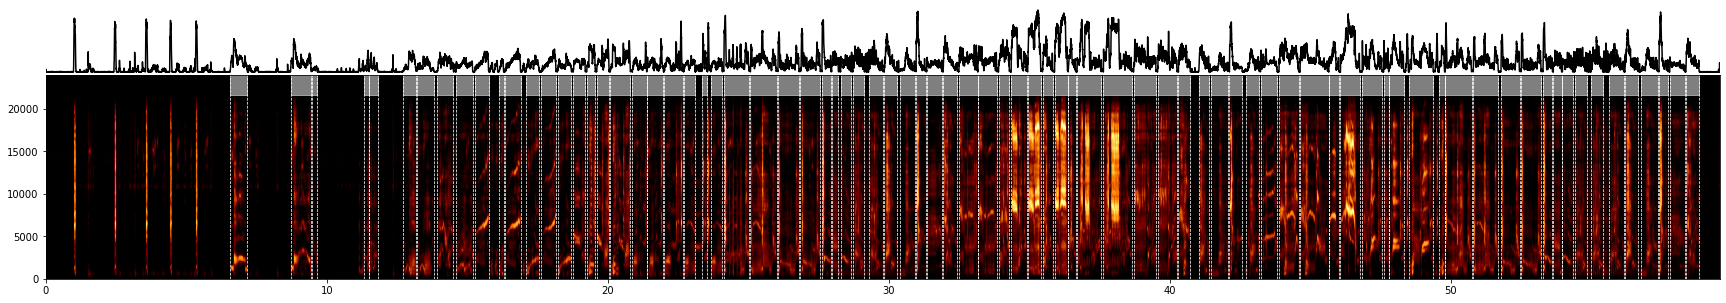

{'onsets': array([ 6.564,  8.712,  9.461, 11.317, 11.508, 12.731, 13.204, 13.936,
        14.603, 15.267, 16.136, 16.348, 17.092, 17.64 , 18.214, 18.778,
        19.254, 19.607, 20.093, 20.877, 21.39 , 21.999, 22.704, 23.346,
        23.667, 24.127, 25.078, 26.054, 26.855, 27.62 , 27.967, 28.286,
        28.725, 29.283, 29.84 , 30.391, 30.967, 31.346, 31.936, 32.495,
        33.173, 33.905, 34.354, 34.943, 35.47 , 35.899, 36.385, 36.699,
        37.638, 38.714, 39.567, 40.308, 41.033, 41.465, 42.123, 42.719,
        43.228, 43.885, 44.636, 45.657, 46.071, 46.844, 47.608, 47.795,
        48.526, 49.584, 49.799, 50.799, 51.784, 52.502, 53.281, 53.645,
        53.972, 54.418, 54.991, 55.626, 56.195, 56.753, 57.407, 57.788,
        58.364]),
 'offsets': array([ 7.172,  9.454,  9.663, 11.505, 11.82 , 13.189, 13.809, 14.509,
        15.195, 15.765, 16.293, 16.9  , 17.563, 18.16 , 18.703, 19.207,
        19.557, 20.046, 20.804, 21.383, 21.983, 22.693, 23.107, 23.52 ,
        24.07 , 25.027, 2

In [10]:
segment_spec_custom(ae_df['waveform'].values[0], rate = 48000, plot = True)

## Run on whole dataset

In [11]:
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm

n_jobs = 36
verbose = 0

In [ ]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    segs = parallel(
        delayed(segment_spec_custom)(
            data, 
            rate = 48000, 
            plot = False
        )
        for data in tqdm(ae_df['waveform'].values, desc = 'Segmenting all songs')
    )

Segmenting all songs:   3%|▎         | 36/1041 [00:17<08:06,  2.07it/s]

In [ ]:
ae_df['segmentations'] = segs

## make syllable_df
> 1. for each bout, create rows for all onset and offsets

In [ ]:
## make columns
ae_df_index = []
indv = []
start_ms = []
end_ms = []
file = []

onsets_ms = []
offsets_ms = []

## for each bout
for bout in ae_df.iterrows():
    
    index = bout[0]
    bout_info = bout[1]
    
    ## get each syllable
    for onset, offset in zip(bout_info.segmentations['onsets'], bout_info.segmentations['offsets']):
        
        ## populate columns
        ae_df_index.append(index)
        indv.append('b1555')
        start_ms.append(bout_info.start_ms)
        end_ms.append(bout_info.end_ms)
        file.append(bout_info.file)
        onsets_ms.append(onset)
        offsets_ms.append(offset)
        
        
syllable_df = pd.DataFrame(
    {
        'ae_df_index': ae_df_index,
        'indv': indv,
        'start_ms': start_ms,
        'end_ms': end_ms,
        'file': file,
        'onsets_ms': onsets_ms,
        'offsets_ms': offsets_ms
    }
)

In [ ]:
syllable_df

## Pickle dataframe

In [ ]:
from starling_rhythm.utils.paths import PROCESSED_DIR, ensure_dir

In [ ]:
SAVE_PATH = PROCESSED_DIR / 'starling_b1555_syllable_df.pickle'
ensure_dir(SAVE_PATH)

In [ ]:
syllable_df.to_pickle(SAVE_PATH)